In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(4e4)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ETA = 0.5
ALPHA = 0.5
LAMBDA = 0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/ista')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

# Data

In [8]:
def forward(a, b, x):
    if a.shape[1] == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ a.shape[1]

In [9]:
# Teacher Network
m_star = 50 # number of teacher neurons
eps = 3e-1

a_star = 2 * np.sign(np.random.uniform(size=(1, m_star)) - 0.5) / np.sqrt(m_star)
b_star = 2 * np.random.uniform(size=(m_star, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m_star, INPUT_DIM))**2

In [10]:
# Data
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
train_norms = np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
x_train = x_train / train_norms
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM)) / np.sqrt(INPUT_DIM)
val_norms = np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
x_val = x_val / val_norms
y_val = forward(a_star, b_star, x_val)

In [11]:
print(np.max(np.linalg.norm(x_train, axis=1, ord=2)))
print(np.max(np.linalg.norm(x_val, axis=1, ord=2)))

1.0
1.0000000000000002


# Algorithm iterations

In [12]:
def compute_losses(a, b, x, y, penalized=True):
    y_hat = forward(a, b, x)
    loss_ = 0.5 * np.mean((y_hat - y)**2)
    if penalized:
        penalized_loss = loss_ + LAMBDA * np.sum(np.abs(a))
    else:
        0.
    return loss_, penalized_loss

In [13]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(N_STEPS)):
        # sample and update iteration in 2 stpes
        a, b = add_new_neuron(a, b, x_train, y_train, eps=EPS)
        ms.append(a.shape[1])
        a, b = update_random_neuron(a, b, x_train, y_train, eps=EPS)
        ms.append(a.shape[1])
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [14]:
def add_new_neuron(a, b, x, y, eps=1.0e-6):
    #neurons_scale = np.sqrt(INPUT_DIM)
    new_b = np.random.normal(size=(1, INPUT_DIM))
    neurons_scale = np.linalg.norm(new_b, axis=1, ord=2)
    # new_b = new_b / np.sqrt(np.sum(new_b**2))
    new_b = new_b / neurons_scale
    V = V_grad(a, b, x, y, new_b)
    new_a = ETA * soft_thresholding(V, tau=LAMBDA)
    
    if np.abs(new_a) > eps:
        if a.shape[1] == 0:
            a = np.array([[new_a]])
            b = new_b
        else:
            a = np.column_stack((a, [new_a]))
            b = np.row_stack((b, new_b))
    
    return a, b 

In [15]:
def update_random_neuron(a, b, x, y, eps=1.0e-6):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :]
        V = V_grad(a, b, x, y, b_j) - a[0, j] / ALPHA 
        new_a = ALPHA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > eps:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
    return a, b  

$$\text{soft_thresholding}(V, \tau) = -\text{sign}(V) \times \max\Big(0,|V| - \tau \Big) $$

In [16]:
def soft_thresholding(V, tau):
    return - np.sign(V) * np.maximum(0, np.abs(V) - tau)

In [17]:
def V_grad(a, b, x, y, new_b):
    y_hat = forward(a, b, x)
    return np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0))

In [71]:
INPUT_DIM = 50
ms = [1, 5, 20, 50, 100, 256, 1000, 5000, 10000]
n_rep = 100
lip_consts = []
for m in ms:
    for _ in range(n_rep):
        a_1 = np.random.normal(size=(1, m))
        b_1 = np.random.normal(size=(m, INPUT_DIM))
        norms_1 = np.linalg.norm(b_1, axis=1, ord=2, keepdims=True)
        b_1 = b_1 / norms_1

        a_2 = np.random.normal(size=(1, m))
        b_2 = np.random.normal(size=(m, INPUT_DIM))
        norms_2 = np.linalg.norm(b_2, axis=1, ord=2, keepdims=True)
        b_2 = b_2 / norms_2

        b_ = np.random.normal(size=(1, INPUT_DIM))
        norm = np.linalg.norm(b_, axis=1, ord=2, keepdims=True)
        b_ = b_ / norm

        V_1 = V_grad(a_1, b_1, x_train, y_train, b_)
        V_2 = V_grad(a_2, b_2, x_train, y_train, b_)

        lip_consts.append(np.abs(V_1 - V_2) / (np.sum(np.abs(a_1)))) 
        
lip_consts = np.array(lip_consts)

In [72]:
np.max(lip_consts)

0.7504042554380439

In [73]:
np.mean(lip_consts)

0.0023491291242041462

In [74]:
np.median(lip_consts)

0.00029582880990746416

In [75]:
np.std(lip_consts)

0.025937777060158228

In [76]:
np.percentile(lip_consts, q=99)

0.015400674776549939

In [18]:
def forward_states(a, b, x):
    x_1 = np.maximum(np.matmul(x, b.T), 0)
    y_hat = np.matmul(x_1, a.T) #/ a.shape[1]
    return x_1, y_hat

In [19]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses = \
        train(N_STEPS, x_train, y_train, x_val, y_val)

  1%|▏                                    | 215/40000 [00:00<00:35, 1106.28it/s]

m at step 0 : 1
Train loss at step 0 : 0.40157
Validation loss at step 0 : 0.36975
m at step 100 : 65
Train loss at step 100 : 0.39182
Validation loss at step 100 : 0.36041
m at step 200 : 118
Train loss at step 200 : 0.38585
Validation loss at step 200 : 0.35458


  1%|▍                                     | 429/40000 [00:00<00:40, 973.06it/s]

m at step 300 : 161
Train loss at step 300 : 0.38058
Validation loss at step 300 : 0.34935
m at step 400 : 199
Train loss at step 400 : 0.37673
Validation loss at step 400 : 0.34573


  2%|▌                                     | 617/40000 [00:00<00:47, 824.83it/s]

m at step 500 : 227
Train loss at step 500 : 0.37314
Validation loss at step 500 : 0.34240
m at step 600 : 266
Train loss at step 600 : 0.36906
Validation loss at step 600 : 0.33836


  2%|▋                                     | 778/40000 [00:00<00:55, 708.41it/s]

m at step 700 : 285
Train loss at step 700 : 0.36657
Validation loss at step 700 : 0.33640
m at step 800 : 312
Train loss at step 800 : 0.36586
Validation loss at step 800 : 0.33591


  2%|▉                                     | 971/40000 [00:01<01:13, 531.60it/s]

m at step 900 : 332
Train loss at step 900 : 0.36460
Validation loss at step 900 : 0.33457
m at step 1,000 : 359
Train loss at step 1,000 : 0.36339
Validation loss at step 1,000 : 0.33344


  3%|█                                    | 1171/40000 [00:01<01:37, 397.26it/s]

m at step 1,100 : 386
Train loss at step 1,100 : 0.36207
Validation loss at step 1,100 : 0.33225


  3%|█▏                                   | 1259/40000 [00:02<01:33, 414.10it/s]

m at step 1,200 : 408
Train loss at step 1,200 : 0.36042
Validation loss at step 1,200 : 0.33027


  3%|█▏                                   | 1344/40000 [00:02<01:36, 401.19it/s]

m at step 1,300 : 416
Train loss at step 1,300 : 0.35939
Validation loss at step 1,300 : 0.32918


  4%|█▎                                   | 1482/40000 [00:02<01:30, 426.43it/s]

m at step 1,400 : 438
Train loss at step 1,400 : 0.35860
Validation loss at step 1,400 : 0.32858


  4%|█▍                                   | 1569/40000 [00:02<01:31, 420.48it/s]

m at step 1,500 : 449
Train loss at step 1,500 : 0.35777
Validation loss at step 1,500 : 0.32808


  4%|█▌                                   | 1652/40000 [00:03<01:49, 351.27it/s]

m at step 1,600 : 470
Train loss at step 1,600 : 0.35690
Validation loss at step 1,600 : 0.32740


  4%|█▋                                   | 1781/40000 [00:03<01:38, 389.90it/s]

m at step 1,700 : 471
Train loss at step 1,700 : 0.35575
Validation loss at step 1,700 : 0.32638


  5%|█▋                                   | 1859/40000 [00:03<01:54, 333.20it/s]

m at step 1,800 : 468
Train loss at step 1,800 : 0.35602
Validation loss at step 1,800 : 0.32665


  5%|█▊                                   | 1967/40000 [00:04<01:54, 333.15it/s]

m at step 1,900 : 468
Train loss at step 1,900 : 0.35648
Validation loss at step 1,900 : 0.32719


  5%|█▉                                   | 2042/40000 [00:04<01:48, 351.27it/s]

m at step 2,000 : 477
Train loss at step 2,000 : 0.35642
Validation loss at step 2,000 : 0.32706


  5%|██                                   | 2182/40000 [00:04<01:31, 412.49it/s]

m at step 2,100 : 477
Train loss at step 2,100 : 0.35652
Validation loss at step 2,100 : 0.32713


  6%|██                                   | 2270/40000 [00:04<01:34, 399.84it/s]

m at step 2,200 : 478
Train loss at step 2,200 : 0.35656
Validation loss at step 2,200 : 0.32758


  6%|██▏                                  | 2360/40000 [00:05<01:32, 406.52it/s]

m at step 2,300 : 483
Train loss at step 2,300 : 0.35638
Validation loss at step 2,300 : 0.32742


  6%|██▎                                  | 2443/40000 [00:05<01:41, 369.19it/s]

m at step 2,400 : 501
Train loss at step 2,400 : 0.35573
Validation loss at step 2,400 : 0.32687


  6%|██▎                                  | 2561/40000 [00:05<01:51, 336.71it/s]

m at step 2,500 : 520
Train loss at step 2,500 : 0.35532
Validation loss at step 2,500 : 0.32624


  7%|██▍                                  | 2671/40000 [00:06<01:51, 335.60it/s]

m at step 2,600 : 526
Train loss at step 2,600 : 0.35447
Validation loss at step 2,600 : 0.32555


  7%|██▌                                  | 2754/40000 [00:06<01:39, 373.85it/s]

m at step 2,700 : 530
Train loss at step 2,700 : 0.35463
Validation loss at step 2,700 : 0.32595


  7%|██▋                                  | 2879/40000 [00:06<01:32, 401.04it/s]

m at step 2,800 : 532
Train loss at step 2,800 : 0.35512
Validation loss at step 2,800 : 0.32600


  7%|██▋                                  | 2960/40000 [00:06<01:35, 387.52it/s]

m at step 2,900 : 543
Train loss at step 2,900 : 0.35456
Validation loss at step 2,900 : 0.32541


  8%|██▊                                  | 3081/40000 [00:07<01:37, 380.49it/s]

m at step 3,000 : 552
Train loss at step 3,000 : 0.35436
Validation loss at step 3,000 : 0.32530


  8%|██▉                                  | 3158/40000 [00:07<01:47, 344.16it/s]

m at step 3,100 : 551
Train loss at step 3,100 : 0.35477
Validation loss at step 3,100 : 0.32575


  8%|██▉                                  | 3236/40000 [00:07<01:40, 365.27it/s]

m at step 3,200 : 550
Train loss at step 3,200 : 0.35507
Validation loss at step 3,200 : 0.32634


  8%|███                                  | 3341/40000 [00:07<02:01, 301.56it/s]

m at step 3,300 : 555
Train loss at step 3,300 : 0.35481
Validation loss at step 3,300 : 0.32626


  9%|███▏                                 | 3452/40000 [00:08<01:44, 348.74it/s]

m at step 3,400 : 558
Train loss at step 3,400 : 0.35524
Validation loss at step 3,400 : 0.32664


  9%|███▎                                 | 3569/40000 [00:08<01:36, 376.85it/s]

m at step 3,500 : 559
Train loss at step 3,500 : 0.35509
Validation loss at step 3,500 : 0.32674


  9%|███▎                                 | 3645/40000 [00:08<01:37, 372.88it/s]

m at step 3,600 : 563
Train loss at step 3,600 : 0.35443
Validation loss at step 3,600 : 0.32599


  9%|███▍                                 | 3765/40000 [00:09<01:33, 389.54it/s]

m at step 3,700 : 560
Train loss at step 3,700 : 0.35392
Validation loss at step 3,700 : 0.32576


 10%|███▌                                 | 3840/40000 [00:09<01:49, 330.99it/s]

m at step 3,800 : 557
Train loss at step 3,800 : 0.35333
Validation loss at step 3,800 : 0.32516


 10%|███▌                                 | 3918/40000 [00:09<01:41, 356.48it/s]

m at step 3,900 : 558
Train loss at step 3,900 : 0.35315
Validation loss at step 3,900 : 0.32525


 10%|███▋                                 | 4053/40000 [00:10<02:05, 285.84it/s]

m at step 4,000 : 568
Train loss at step 4,000 : 0.35237
Validation loss at step 4,000 : 0.32441


 10%|███▊                                 | 4172/40000 [00:10<01:40, 355.86it/s]

m at step 4,100 : 568
Train loss at step 4,100 : 0.35206
Validation loss at step 4,100 : 0.32372


 11%|███▉                                 | 4251/40000 [00:10<01:35, 374.69it/s]

m at step 4,200 : 563
Train loss at step 4,200 : 0.35226
Validation loss at step 4,200 : 0.32410


 11%|████                                 | 4366/40000 [00:10<01:38, 361.93it/s]

m at step 4,300 : 569
Train loss at step 4,300 : 0.35243
Validation loss at step 4,300 : 0.32437


 11%|████                                 | 4441/40000 [00:11<01:47, 330.63it/s]

m at step 4,400 : 573
Train loss at step 4,400 : 0.35201
Validation loss at step 4,400 : 0.32393


 11%|████▏                                | 4556/40000 [00:11<01:41, 350.38it/s]

m at step 4,500 : 562
Train loss at step 4,500 : 0.35273
Validation loss at step 4,500 : 0.32464


 12%|████▎                                | 4658/40000 [00:11<01:57, 301.59it/s]

m at step 4,600 : 564
Train loss at step 4,600 : 0.35271
Validation loss at step 4,600 : 0.32449


 12%|████▍                                | 4770/40000 [00:12<01:42, 342.72it/s]

m at step 4,700 : 577
Train loss at step 4,700 : 0.35260
Validation loss at step 4,700 : 0.32450


 12%|████▍                                | 4843/40000 [00:12<01:43, 338.92it/s]

m at step 4,800 : 571
Train loss at step 4,800 : 0.35267
Validation loss at step 4,800 : 0.32480


 12%|████▌                                | 4953/40000 [00:12<01:43, 339.45it/s]

m at step 4,900 : 563
Train loss at step 4,900 : 0.35306
Validation loss at step 4,900 : 0.32550


 13%|████▋                                | 5069/40000 [00:13<01:34, 369.10it/s]

m at step 5,000 : 566
Train loss at step 5,000 : 0.35262
Validation loss at step 5,000 : 0.32517


 13%|████▊                                | 5141/40000 [00:13<01:50, 314.72it/s]

m at step 5,100 : 561
Train loss at step 5,100 : 0.35243
Validation loss at step 5,100 : 0.32514


 13%|████▊                                | 5250/40000 [00:13<01:50, 315.42it/s]

m at step 5,200 : 571
Train loss at step 5,200 : 0.35253
Validation loss at step 5,200 : 0.32535


 13%|████▉                                | 5345/40000 [00:13<02:01, 284.96it/s]

m at step 5,300 : 567
Train loss at step 5,300 : 0.35333
Validation loss at step 5,300 : 0.32613


 14%|█████                                | 5453/40000 [00:14<01:47, 320.82it/s]

m at step 5,400 : 575
Train loss at step 5,400 : 0.35252
Validation loss at step 5,400 : 0.32533


 14%|█████▏                               | 5570/40000 [00:14<01:34, 363.47it/s]

m at step 5,500 : 585
Train loss at step 5,500 : 0.35213
Validation loss at step 5,500 : 0.32480


 14%|█████▏                               | 5646/40000 [00:14<01:35, 360.06it/s]

m at step 5,600 : 599
Train loss at step 5,600 : 0.35128
Validation loss at step 5,600 : 0.32391


 14%|█████▎                               | 5758/40000 [00:15<01:46, 321.14it/s]

m at step 5,700 : 600
Train loss at step 5,700 : 0.35144
Validation loss at step 5,700 : 0.32417


 15%|█████▍                               | 5865/40000 [00:15<01:41, 336.95it/s]

m at step 5,800 : 599
Train loss at step 5,800 : 0.35182
Validation loss at step 5,800 : 0.32483


 15%|█████▍                               | 5932/40000 [00:15<01:58, 288.14it/s]

m at step 5,900 : 586
Train loss at step 5,900 : 0.35261
Validation loss at step 5,900 : 0.32552


 15%|█████▌                               | 6069/40000 [00:16<01:42, 330.27it/s]

m at step 6,000 : 581
Train loss at step 6,000 : 0.35294
Validation loss at step 6,000 : 0.32607


 15%|█████▋                               | 6145/40000 [00:16<01:36, 352.01it/s]

m at step 6,100 : 578
Train loss at step 6,100 : 0.35185
Validation loss at step 6,100 : 0.32506


 16%|█████▊                               | 6267/40000 [00:16<01:28, 379.86it/s]

m at step 6,200 : 576
Train loss at step 6,200 : 0.35188
Validation loss at step 6,200 : 0.32505


 16%|█████▊                               | 6343/40000 [00:16<01:40, 333.51it/s]

m at step 6,300 : 582
Train loss at step 6,300 : 0.35148
Validation loss at step 6,300 : 0.32472


 16%|█████▉                               | 6445/40000 [00:17<01:50, 304.85it/s]

m at step 6,400 : 580
Train loss at step 6,400 : 0.35186
Validation loss at step 6,400 : 0.32502


 16%|██████                               | 6550/40000 [00:17<01:50, 302.33it/s]

m at step 6,500 : 582
Train loss at step 6,500 : 0.35218
Validation loss at step 6,500 : 0.32555


 17%|██████▏                              | 6645/40000 [00:18<01:54, 292.28it/s]

m at step 6,600 : 587
Train loss at step 6,600 : 0.35198
Validation loss at step 6,600 : 0.32530


 17%|██████▏                              | 6753/40000 [00:18<01:40, 330.98it/s]

m at step 6,700 : 586
Train loss at step 6,700 : 0.35134
Validation loss at step 6,700 : 0.32463


 17%|██████▎                              | 6875/40000 [00:18<01:27, 379.52it/s]

m at step 6,800 : 586
Train loss at step 6,800 : 0.35197
Validation loss at step 6,800 : 0.32541


 17%|██████▍                              | 6958/40000 [00:18<01:24, 390.18it/s]

m at step 6,900 : 578
Train loss at step 6,900 : 0.35251
Validation loss at step 6,900 : 0.32587


 18%|██████▌                              | 7038/40000 [00:19<01:24, 390.20it/s]

m at step 7,000 : 569
Train loss at step 7,000 : 0.35291
Validation loss at step 7,000 : 0.32641


 18%|██████▌                              | 7160/40000 [00:19<01:28, 370.46it/s]

m at step 7,100 : 565
Train loss at step 7,100 : 0.35283
Validation loss at step 7,100 : 0.32654


 18%|██████▋                              | 7234/40000 [00:19<01:48, 302.45it/s]

m at step 7,200 : 559
Train loss at step 7,200 : 0.35261
Validation loss at step 7,200 : 0.32647


 18%|██████▊                              | 7380/40000 [00:20<01:35, 342.36it/s]

m at step 7,300 : 561
Train loss at step 7,300 : 0.35203
Validation loss at step 7,300 : 0.32594


 19%|██████▉                              | 7458/40000 [00:20<01:29, 362.82it/s]

m at step 7,400 : 558
Train loss at step 7,400 : 0.35176
Validation loss at step 7,400 : 0.32608


 19%|███████                              | 7583/40000 [00:20<01:21, 395.84it/s]

m at step 7,500 : 559
Train loss at step 7,500 : 0.35218
Validation loss at step 7,500 : 0.32630


 19%|███████                              | 7666/40000 [00:20<01:20, 400.61it/s]

m at step 7,600 : 558
Train loss at step 7,600 : 0.35252
Validation loss at step 7,600 : 0.32652


 19%|███████▏                             | 7747/40000 [00:21<01:29, 359.60it/s]

m at step 7,700 : 563
Train loss at step 7,700 : 0.35207
Validation loss at step 7,700 : 0.32582


 20%|███████▎                             | 7863/40000 [00:21<01:30, 355.11it/s]

m at step 7,800 : 562
Train loss at step 7,800 : 0.35219
Validation loss at step 7,800 : 0.32577


 20%|███████▎                             | 7936/40000 [00:21<01:40, 319.73it/s]

m at step 7,900 : 565
Train loss at step 7,900 : 0.35203
Validation loss at step 7,900 : 0.32563


 20%|███████▍                             | 8042/40000 [00:22<01:38, 324.63it/s]

m at step 8,000 : 559
Train loss at step 8,000 : 0.35237
Validation loss at step 8,000 : 0.32590


 20%|███████▌                             | 8166/40000 [00:22<01:24, 377.97it/s]

m at step 8,100 : 559
Train loss at step 8,100 : 0.35282
Validation loss at step 8,100 : 0.32659


 21%|███████▋                             | 8250/40000 [00:22<01:19, 397.97it/s]

m at step 8,200 : 561
Train loss at step 8,200 : 0.35306
Validation loss at step 8,200 : 0.32640


 21%|███████▋                             | 8373/40000 [00:22<01:19, 398.36it/s]

m at step 8,300 : 565
Train loss at step 8,300 : 0.35290
Validation loss at step 8,300 : 0.32627


 21%|███████▊                             | 8453/40000 [00:23<01:21, 386.97it/s]

m at step 8,400 : 577
Train loss at step 8,400 : 0.35308
Validation loss at step 8,400 : 0.32637


 21%|███████▉                             | 8573/40000 [00:23<01:25, 366.34it/s]

m at step 8,500 : 571
Train loss at step 8,500 : 0.35375
Validation loss at step 8,500 : 0.32688


 22%|████████                             | 8649/40000 [00:23<01:33, 334.09it/s]

m at step 8,600 : 572
Train loss at step 8,600 : 0.35324
Validation loss at step 8,600 : 0.32634


 22%|████████                             | 8752/40000 [00:24<01:39, 313.02it/s]

m at step 8,700 : 578
Train loss at step 8,700 : 0.35270
Validation loss at step 8,700 : 0.32580


 22%|████████▏                            | 8869/40000 [00:24<01:25, 362.12it/s]

m at step 8,800 : 583
Train loss at step 8,800 : 0.35266
Validation loss at step 8,800 : 0.32542


 22%|████████▎                            | 8948/40000 [00:24<01:22, 378.41it/s]

m at step 8,900 : 568
Train loss at step 8,900 : 0.35301
Validation loss at step 8,900 : 0.32570


 23%|████████▍                            | 9068/40000 [00:24<01:20, 386.03it/s]

m at step 9,000 : 580
Train loss at step 9,000 : 0.35220
Validation loss at step 9,000 : 0.32514


 23%|████████▍                            | 9146/40000 [00:25<01:21, 379.85it/s]

m at step 9,100 : 577
Train loss at step 9,100 : 0.35259
Validation loss at step 9,100 : 0.32565


 23%|████████▌                            | 9263/40000 [00:25<01:25, 358.51it/s]

m at step 9,200 : 573
Train loss at step 9,200 : 0.35219
Validation loss at step 9,200 : 0.32511


 23%|████████▋                            | 9337/40000 [00:25<01:31, 335.61it/s]

m at step 9,300 : 577
Train loss at step 9,300 : 0.35191
Validation loss at step 9,300 : 0.32489


 24%|████████▋                            | 9436/40000 [00:25<01:42, 298.95it/s]

m at step 9,400 : 565
Train loss at step 9,400 : 0.35213
Validation loss at step 9,400 : 0.32530


 24%|████████▊                            | 9559/40000 [00:26<01:22, 367.11it/s]

m at step 9,500 : 562
Train loss at step 9,500 : 0.35177
Validation loss at step 9,500 : 0.32504


 24%|████████▉                            | 9686/40000 [00:26<01:14, 404.48it/s]

m at step 9,600 : 565
Train loss at step 9,600 : 0.35188
Validation loss at step 9,600 : 0.32521


 24%|█████████                            | 9771/40000 [00:26<01:14, 407.77it/s]

m at step 9,700 : 560
Train loss at step 9,700 : 0.35213
Validation loss at step 9,700 : 0.32557


 25%|█████████                            | 9855/40000 [00:27<01:13, 410.69it/s]

m at step 9,800 : 557
Train loss at step 9,800 : 0.35222
Validation loss at step 9,800 : 0.32554


 25%|█████████▏                           | 9975/40000 [00:27<01:23, 359.22it/s]

m at step 9,900 : 560
Train loss at step 9,900 : 0.35123
Validation loss at step 9,900 : 0.32458


 25%|█████████                           | 10053/40000 [00:27<01:24, 354.37it/s]

m at step 10,000 : 561
Train loss at step 10,000 : 0.35194
Validation loss at step 10,000 : 0.32522


 25%|█████████▏                          | 10156/40000 [00:27<01:37, 307.44it/s]

m at step 10,100 : 551
Train loss at step 10,100 : 0.35236
Validation loss at step 10,100 : 0.32576


 26%|█████████▎                          | 10282/40000 [00:28<01:18, 377.99it/s]

m at step 10,200 : 550
Train loss at step 10,200 : 0.35253
Validation loss at step 10,200 : 0.32626


 26%|█████████▎                          | 10367/40000 [00:28<01:13, 401.31it/s]

m at step 10,300 : 547
Train loss at step 10,300 : 0.35216
Validation loss at step 10,300 : 0.32604


 26%|█████████▍                          | 10450/40000 [00:28<01:12, 405.19it/s]

m at step 10,400 : 535
Train loss at step 10,400 : 0.35296
Validation loss at step 10,400 : 0.32668


 26%|█████████▌                          | 10584/40000 [00:28<01:08, 431.84it/s]

m at step 10,500 : 540
Train loss at step 10,500 : 0.35304
Validation loss at step 10,500 : 0.32681


 27%|█████████▌                          | 10628/40000 [00:29<01:15, 391.36it/s]

m at step 10,600 : 531
Train loss at step 10,600 : 0.35367
Validation loss at step 10,600 : 0.32765


 27%|█████████▋                          | 10760/40000 [00:29<01:12, 404.03it/s]

m at step 10,700 : 524
Train loss at step 10,700 : 0.35404
Validation loss at step 10,700 : 0.32787


 27%|█████████▊                          | 10841/40000 [00:29<01:24, 343.66it/s]

m at step 10,800 : 525
Train loss at step 10,800 : 0.35316
Validation loss at step 10,800 : 0.32706


 27%|█████████▊                          | 10954/40000 [00:30<01:23, 345.82it/s]

m at step 10,900 : 530
Train loss at step 10,900 : 0.35319
Validation loss at step 10,900 : 0.32693


 28%|█████████▉                          | 11085/40000 [00:30<01:11, 402.42it/s]

m at step 11,000 : 534
Train loss at step 11,000 : 0.35308
Validation loss at step 11,000 : 0.32683


 28%|██████████                          | 11169/40000 [00:30<01:10, 406.88it/s]

m at step 11,100 : 521
Train loss at step 11,100 : 0.35339
Validation loss at step 11,100 : 0.32658


 28%|██████████▏                         | 11257/40000 [00:30<01:08, 417.41it/s]

m at step 11,200 : 534
Train loss at step 11,200 : 0.35277
Validation loss at step 11,200 : 0.32564


 28%|██████████▏                         | 11344/40000 [00:30<01:07, 424.94it/s]

m at step 11,300 : 542
Train loss at step 11,300 : 0.35252
Validation loss at step 11,300 : 0.32529


 29%|██████████▎                         | 11472/40000 [00:31<01:17, 368.83it/s]

m at step 11,400 : 536
Train loss at step 11,400 : 0.35194
Validation loss at step 11,400 : 0.32476


 29%|██████████▍                         | 11551/40000 [00:31<01:18, 360.39it/s]

m at step 11,500 : 526
Train loss at step 11,500 : 0.35244
Validation loss at step 11,500 : 0.32513


 29%|██████████▍                         | 11655/40000 [00:31<01:29, 316.22it/s]

m at step 11,600 : 535
Train loss at step 11,600 : 0.35162
Validation loss at step 11,600 : 0.32451


 29%|██████████▌                         | 11780/40000 [00:32<01:15, 373.78it/s]

m at step 11,700 : 547
Train loss at step 11,700 : 0.35172
Validation loss at step 11,700 : 0.32481


 30%|██████████▋                         | 11869/40000 [00:32<01:08, 408.25it/s]

m at step 11,800 : 534
Train loss at step 11,800 : 0.35181
Validation loss at step 11,800 : 0.32501


 30%|██████████▊                         | 11953/40000 [00:32<01:08, 409.91it/s]

m at step 11,900 : 523
Train loss at step 11,900 : 0.35241
Validation loss at step 11,900 : 0.32574


 30%|██████████▉                         | 12087/40000 [00:32<01:04, 433.33it/s]

m at step 12,000 : 521
Train loss at step 12,000 : 0.35153
Validation loss at step 12,000 : 0.32481


 30%|██████████▉                         | 12131/40000 [00:33<01:10, 392.63it/s]

m at step 12,100 : 519
Train loss at step 12,100 : 0.35172
Validation loss at step 12,100 : 0.32525


 31%|███████████                         | 12263/40000 [00:33<01:08, 405.13it/s]

m at step 12,200 : 522
Train loss at step 12,200 : 0.35206
Validation loss at step 12,200 : 0.32570


 31%|███████████                         | 12345/40000 [00:33<01:18, 350.08it/s]

m at step 12,300 : 524
Train loss at step 12,300 : 0.35164
Validation loss at step 12,300 : 0.32535


 31%|███████████▏                        | 12460/40000 [00:34<01:18, 352.18it/s]

m at step 12,400 : 529
Train loss at step 12,400 : 0.35186
Validation loss at step 12,400 : 0.32558


 31%|███████████▎                        | 12546/40000 [00:34<01:10, 389.17it/s]

m at step 12,500 : 540
Train loss at step 12,500 : 0.35245
Validation loss at step 12,500 : 0.32603


 32%|███████████▍                        | 12674/40000 [00:34<01:08, 397.76it/s]

m at step 12,600 : 544
Train loss at step 12,600 : 0.35232
Validation loss at step 12,600 : 0.32580


 32%|███████████▍                        | 12760/40000 [00:34<01:07, 401.21it/s]

m at step 12,700 : 556
Train loss at step 12,700 : 0.35158
Validation loss at step 12,700 : 0.32515


 32%|███████████▌                        | 12844/40000 [00:34<01:06, 407.03it/s]

m at step 12,800 : 553
Train loss at step 12,800 : 0.35177
Validation loss at step 12,800 : 0.32528


 32%|███████████▋                        | 12967/40000 [00:35<01:13, 370.21it/s]

m at step 12,900 : 543
Train loss at step 12,900 : 0.35257
Validation loss at step 12,900 : 0.32569


 33%|███████████▋                        | 13047/40000 [00:35<01:10, 382.35it/s]

m at step 13,000 : 540
Train loss at step 13,000 : 0.35234
Validation loss at step 13,000 : 0.32535


 33%|███████████▊                        | 13155/40000 [00:35<01:24, 318.62it/s]

m at step 13,100 : 540
Train loss at step 13,100 : 0.35261
Validation loss at step 13,100 : 0.32577


 33%|███████████▉                        | 13283/40000 [00:36<01:08, 389.82it/s]

m at step 13,200 : 531
Train loss at step 13,200 : 0.35281
Validation loss at step 13,200 : 0.32607


 33%|████████████                        | 13370/40000 [00:36<01:04, 413.25it/s]

m at step 13,300 : 525
Train loss at step 13,300 : 0.35252
Validation loss at step 13,300 : 0.32561


 34%|████████████                        | 13458/40000 [00:36<01:02, 422.40it/s]

m at step 13,400 : 514
Train loss at step 13,400 : 0.35210
Validation loss at step 13,400 : 0.32516


 34%|████████████▏                       | 13549/40000 [00:36<01:00, 439.57it/s]

m at step 13,500 : 505
Train loss at step 13,500 : 0.35269
Validation loss at step 13,500 : 0.32553


 34%|████████████▎                       | 13646/40000 [00:37<01:00, 438.57it/s]

m at step 13,600 : 500
Train loss at step 13,600 : 0.35264
Validation loss at step 13,600 : 0.32558


 34%|████████████▍                       | 13788/40000 [00:37<01:01, 427.85it/s]

m at step 13,700 : 493
Train loss at step 13,700 : 0.35253
Validation loss at step 13,700 : 0.32554


 35%|████████████▍                       | 13832/40000 [00:37<01:02, 422.03it/s]

m at step 13,800 : 492
Train loss at step 13,800 : 0.35281
Validation loss at step 13,800 : 0.32583


 35%|████████████▌                       | 13953/40000 [00:37<01:14, 351.69it/s]

m at step 13,900 : 489
Train loss at step 13,900 : 0.35267
Validation loss at step 13,900 : 0.32547


 35%|████████████▋                       | 14087/40000 [00:38<01:02, 414.60it/s]

m at step 14,000 : 492
Train loss at step 14,000 : 0.35247
Validation loss at step 14,000 : 0.32509


 35%|████████████▊                       | 14180/40000 [00:38<01:01, 422.27it/s]

m at step 14,100 : 491
Train loss at step 14,100 : 0.35236
Validation loss at step 14,100 : 0.32516


 36%|████████████▊                       | 14275/40000 [00:38<00:57, 447.98it/s]

m at step 14,200 : 484
Train loss at step 14,200 : 0.35248
Validation loss at step 14,200 : 0.32528


 36%|████████████▉                       | 14371/40000 [00:38<00:55, 458.22it/s]

m at step 14,300 : 488
Train loss at step 14,300 : 0.35219
Validation loss at step 14,300 : 0.32514


 36%|█████████████                       | 14464/40000 [00:39<00:58, 435.49it/s]

m at step 14,400 : 491
Train loss at step 14,400 : 0.35166
Validation loss at step 14,400 : 0.32463


 36%|█████████████                       | 14556/40000 [00:39<01:03, 398.86it/s]

m at step 14,500 : 491
Train loss at step 14,500 : 0.35155
Validation loss at step 14,500 : 0.32471


 37%|█████████████▏                      | 14650/40000 [00:39<00:59, 428.76it/s]

m at step 14,600 : 476
Train loss at step 14,600 : 0.35265
Validation loss at step 14,600 : 0.32570


 37%|█████████████▎                      | 14733/40000 [00:39<01:10, 359.55it/s]

m at step 14,700 : 474
Train loss at step 14,700 : 0.35297
Validation loss at step 14,700 : 0.32605


 37%|█████████████▎                      | 14859/40000 [00:40<01:07, 372.99it/s]

m at step 14,800 : 481
Train loss at step 14,800 : 0.35233
Validation loss at step 14,800 : 0.32562


 37%|█████████████▍                      | 14998/40000 [00:40<00:57, 434.23it/s]

m at step 14,900 : 489
Train loss at step 14,900 : 0.35267
Validation loss at step 14,900 : 0.32612


 38%|█████████████▌                      | 15089/40000 [00:40<00:56, 440.13it/s]

m at step 15,000 : 489
Train loss at step 15,000 : 0.35212
Validation loss at step 15,000 : 0.32574


 38%|█████████████▋                      | 15186/40000 [00:40<00:53, 464.75it/s]

m at step 15,100 : 469
Train loss at step 15,100 : 0.35261
Validation loss at step 15,100 : 0.32612
m at step 15,200 : 474
Train loss at step 15,200 : 0.35233
Validation loss at step 15,200 : 0.32605


 38%|█████████████▊                      | 15373/40000 [00:41<00:58, 424.33it/s]

m at step 15,300 : 472
Train loss at step 15,300 : 0.35236
Validation loss at step 15,300 : 0.32578


 39%|█████████████▉                      | 15465/40000 [00:41<00:55, 439.58it/s]

m at step 15,400 : 474
Train loss at step 15,400 : 0.35283
Validation loss at step 15,400 : 0.32640


 39%|█████████████▉                      | 15550/40000 [00:41<01:04, 377.49it/s]

m at step 15,500 : 473
Train loss at step 15,500 : 0.35338
Validation loss at step 15,500 : 0.32678


 39%|██████████████                      | 15691/40000 [00:42<00:57, 422.84it/s]

m at step 15,600 : 462
Train loss at step 15,600 : 0.35368
Validation loss at step 15,600 : 0.32740
m at step 15,700 : 461
Train loss at step 15,700 : 0.35301
Validation loss at step 15,700 : 0.32684


 40%|██████████████▎                     | 15891/40000 [00:42<00:49, 485.47it/s]

m at step 15,800 : 478
Train loss at step 15,800 : 0.35210
Validation loss at step 15,800 : 0.32573
m at step 15,900 : 472
Train loss at step 15,900 : 0.35247
Validation loss at step 15,900 : 0.32587


 40%|██████████████▍                     | 16101/40000 [00:42<00:46, 510.78it/s]

m at step 16,000 : 459
Train loss at step 16,000 : 0.35244
Validation loss at step 16,000 : 0.32595
m at step 16,100 : 455
Train loss at step 16,100 : 0.35271
Validation loss at step 16,100 : 0.32614


 41%|██████████████▋                     | 16251/40000 [00:43<00:53, 442.41it/s]

m at step 16,200 : 460
Train loss at step 16,200 : 0.35218
Validation loss at step 16,200 : 0.32571
m at step 16,300 : 459
Train loss at step 16,300 : 0.35267
Validation loss at step 16,300 : 0.32628


 41%|██████████████▊                     | 16446/40000 [00:43<00:59, 396.88it/s]

m at step 16,400 : 454
Train loss at step 16,400 : 0.35257
Validation loss at step 16,400 : 0.32599


 41%|██████████████▉                     | 16587/40000 [00:44<00:55, 423.54it/s]

m at step 16,500 : 443
Train loss at step 16,500 : 0.35298
Validation loss at step 16,500 : 0.32632
m at step 16,600 : 458
Train loss at step 16,600 : 0.35295
Validation loss at step 16,600 : 0.32621


 42%|███████████████                     | 16786/40000 [00:44<00:48, 483.00it/s]

m at step 16,700 : 471
Train loss at step 16,700 : 0.35239
Validation loss at step 16,700 : 0.32589
m at step 16,800 : 469
Train loss at step 16,800 : 0.35281
Validation loss at step 16,800 : 0.32641


 42%|███████████████▎                    | 16990/40000 [00:45<00:49, 463.72it/s]

m at step 16,900 : 458
Train loss at step 16,900 : 0.35332
Validation loss at step 16,900 : 0.32704


 43%|███████████████▎                    | 17038/40000 [00:45<00:57, 396.75it/s]

m at step 17,000 : 457
Train loss at step 17,000 : 0.35308
Validation loss at step 17,000 : 0.32692


 43%|███████████████▍                    | 17178/40000 [00:45<00:53, 428.61it/s]

m at step 17,100 : 460
Train loss at step 17,100 : 0.35270
Validation loss at step 17,100 : 0.32646


 43%|███████████████▌                    | 17264/40000 [00:45<00:59, 383.88it/s]

m at step 17,200 : 457
Train loss at step 17,200 : 0.35241
Validation loss at step 17,200 : 0.32601


 43%|███████████████▌                    | 17341/40000 [00:45<01:03, 354.83it/s]

m at step 17,300 : 456
Train loss at step 17,300 : 0.35259
Validation loss at step 17,300 : 0.32641


 44%|███████████████▋                    | 17489/40000 [00:46<00:51, 438.31it/s]

m at step 17,400 : 453
Train loss at step 17,400 : 0.35254
Validation loss at step 17,400 : 0.32606


 44%|███████████████▊                    | 17588/40000 [00:46<00:48, 466.37it/s]

m at step 17,500 : 448
Train loss at step 17,500 : 0.35299
Validation loss at step 17,500 : 0.32643
m at step 17,600 : 449
Train loss at step 17,600 : 0.35252
Validation loss at step 17,600 : 0.32616


 44%|████████████████                    | 17795/40000 [00:46<00:43, 510.67it/s]

m at step 17,700 : 448
Train loss at step 17,700 : 0.35232
Validation loss at step 17,700 : 0.32605
m at step 17,800 : 446
Train loss at step 17,800 : 0.35231
Validation loss at step 17,800 : 0.32587


 45%|████████████████▏                   | 17999/40000 [00:47<00:49, 448.42it/s]

m at step 17,900 : 435
Train loss at step 17,900 : 0.35254
Validation loss at step 17,900 : 0.32626
m at step 18,000 : 427
Train loss at step 18,000 : 0.35238
Validation loss at step 18,000 : 0.32605


 45%|████████████████▎                   | 18138/40000 [00:47<00:54, 404.77it/s]

m at step 18,100 : 432
Train loss at step 18,100 : 0.35305
Validation loss at step 18,100 : 0.32669


 46%|████████████████▍                   | 18273/40000 [00:48<00:51, 421.30it/s]

m at step 18,200 : 434
Train loss at step 18,200 : 0.35305
Validation loss at step 18,200 : 0.32664
m at step 18,300 : 440
Train loss at step 18,300 : 0.35287
Validation loss at step 18,300 : 0.32661


 46%|████████████████▋                   | 18479/40000 [00:48<00:43, 495.33it/s]

m at step 18,400 : 428
Train loss at step 18,400 : 0.35230
Validation loss at step 18,400 : 0.32596
m at step 18,500 : 428
Train loss at step 18,500 : 0.35219
Validation loss at step 18,500 : 0.32564


 47%|████████████████▊                   | 18694/40000 [00:48<00:40, 531.66it/s]

m at step 18,600 : 422
Train loss at step 18,600 : 0.35246
Validation loss at step 18,600 : 0.32585
m at step 18,700 : 416
Train loss at step 18,700 : 0.35298
Validation loss at step 18,700 : 0.32646


 47%|█████████████████                   | 18904/40000 [00:49<00:44, 476.09it/s]

m at step 18,800 : 418
Train loss at step 18,800 : 0.35295
Validation loss at step 18,800 : 0.32655
m at step 18,900 : 409
Train loss at step 18,900 : 0.35367
Validation loss at step 18,900 : 0.32704


 48%|█████████████████▏                  | 19051/40000 [00:49<00:49, 421.96it/s]

m at step 19,000 : 420
Train loss at step 19,000 : 0.35372
Validation loss at step 19,000 : 0.32720


 48%|█████████████████▎                  | 19188/40000 [00:50<00:49, 423.32it/s]

m at step 19,100 : 413
Train loss at step 19,100 : 0.35405
Validation loss at step 19,100 : 0.32749


 48%|█████████████████▎                  | 19292/40000 [00:50<00:44, 469.85it/s]

m at step 19,200 : 411
Train loss at step 19,200 : 0.35417
Validation loss at step 19,200 : 0.32765
m at step 19,300 : 406
Train loss at step 19,300 : 0.35412
Validation loss at step 19,300 : 0.32734


 49%|█████████████████▌                  | 19510/40000 [00:50<00:38, 526.55it/s]

m at step 19,400 : 404
Train loss at step 19,400 : 0.35409
Validation loss at step 19,400 : 0.32732
m at step 19,500 : 401
Train loss at step 19,500 : 0.35450
Validation loss at step 19,500 : 0.32788


 49%|█████████████████▋                  | 19679/40000 [00:50<00:36, 551.42it/s]

m at step 19,600 : 405
Train loss at step 19,600 : 0.35434
Validation loss at step 19,600 : 0.32782
m at step 19,700 : 401
Train loss at step 19,700 : 0.35292
Validation loss at step 19,700 : 0.32667


 50%|█████████████████▉                  | 19898/40000 [00:51<00:39, 505.70it/s]

m at step 19,800 : 411
Train loss at step 19,800 : 0.35237
Validation loss at step 19,800 : 0.32608
m at step 19,900 : 401
Train loss at step 19,900 : 0.35310
Validation loss at step 19,900 : 0.32679


 50%|██████████████████                  | 20043/40000 [00:51<00:48, 413.87it/s]

m at step 20,000 : 398
Train loss at step 20,000 : 0.35343
Validation loss at step 20,000 : 0.32711


 51%|██████████████████▏                 | 20202/40000 [00:52<00:40, 485.65it/s]

m at step 20,100 : 398
Train loss at step 20,100 : 0.35278
Validation loss at step 20,100 : 0.32632
m at step 20,200 : 389
Train loss at step 20,200 : 0.35297
Validation loss at step 20,200 : 0.32633


 51%|██████████████████▎                 | 20372/40000 [00:52<00:36, 541.07it/s]

m at step 20,300 : 384
Train loss at step 20,300 : 0.35365
Validation loss at step 20,300 : 0.32734
m at step 20,400 : 377
Train loss at step 20,400 : 0.35397
Validation loss at step 20,400 : 0.32778


 52%|██████████████████▌                 | 20609/40000 [00:52<00:33, 582.63it/s]

m at step 20,500 : 377
Train loss at step 20,500 : 0.35343
Validation loss at step 20,500 : 0.32732
m at step 20,600 : 376
Train loss at step 20,600 : 0.35383
Validation loss at step 20,600 : 0.32769


 52%|██████████████████▋                 | 20779/40000 [00:53<00:38, 495.70it/s]

m at step 20,700 : 365
Train loss at step 20,700 : 0.35408
Validation loss at step 20,700 : 0.32812


 52%|██████████████████▊                 | 20898/40000 [00:53<00:34, 546.11it/s]

m at step 20,800 : 363
Train loss at step 20,800 : 0.35395
Validation loss at step 20,800 : 0.32825
m at step 20,900 : 349
Train loss at step 20,900 : 0.35399
Validation loss at step 20,900 : 0.32827


 53%|██████████████████▉                 | 21055/40000 [00:53<00:41, 460.53it/s]

m at step 21,000 : 356
Train loss at step 21,000 : 0.35411
Validation loss at step 21,000 : 0.32826


 53%|███████████████████                 | 21162/40000 [00:54<00:39, 473.35it/s]

m at step 21,100 : 352
Train loss at step 21,100 : 0.35413
Validation loss at step 21,100 : 0.32821
m at step 21,200 : 347
Train loss at step 21,200 : 0.35415
Validation loss at step 21,200 : 0.32818


 54%|███████████████████▎                | 21418/40000 [00:54<00:31, 596.16it/s]

m at step 21,300 : 348
Train loss at step 21,300 : 0.35412
Validation loss at step 21,300 : 0.32808
m at step 21,400 : 357
Train loss at step 21,400 : 0.35359
Validation loss at step 21,400 : 0.32754


 54%|███████████████████▍                | 21604/40000 [00:54<00:33, 552.94it/s]

m at step 21,500 : 361
Train loss at step 21,500 : 0.35280
Validation loss at step 21,500 : 0.32724
m at step 21,600 : 358
Train loss at step 21,600 : 0.35322
Validation loss at step 21,600 : 0.32768


 54%|███████████████████▌                | 21718/40000 [00:55<00:36, 504.53it/s]

m at step 21,700 : 355
Train loss at step 21,700 : 0.35433
Validation loss at step 21,700 : 0.32878


 55%|███████████████████▋                | 21881/40000 [00:55<00:40, 444.54it/s]

m at step 21,800 : 343
Train loss at step 21,800 : 0.35461
Validation loss at step 21,800 : 0.32876
m at step 21,900 : 342
Train loss at step 21,900 : 0.35487
Validation loss at step 21,900 : 0.32908


 55%|███████████████████▊                | 22067/40000 [00:55<00:42, 418.37it/s]

m at step 22,000 : 351
Train loss at step 22,000 : 0.35451
Validation loss at step 22,000 : 0.32883


 55%|███████████████████▉                | 22186/40000 [00:56<00:35, 507.55it/s]

m at step 22,100 : 340
Train loss at step 22,100 : 0.35485
Validation loss at step 22,100 : 0.32937
m at step 22,200 : 337
Train loss at step 22,200 : 0.35529
Validation loss at step 22,200 : 0.32975


 56%|████████████████████▏               | 22371/40000 [00:56<00:30, 579.72it/s]

m at step 22,300 : 343
Train loss at step 22,300 : 0.35491
Validation loss at step 22,300 : 0.32916
m at step 22,400 : 339
Train loss at step 22,400 : 0.35484
Validation loss at step 22,400 : 0.32903


 57%|████████████████████▎               | 22627/40000 [00:56<00:28, 618.91it/s]

m at step 22,500 : 345
Train loss at step 22,500 : 0.35441
Validation loss at step 22,500 : 0.32856
m at step 22,600 : 332
Train loss at step 22,600 : 0.35441
Validation loss at step 22,600 : 0.32888


 57%|████████████████████▍               | 22752/40000 [00:57<00:31, 540.03it/s]

m at step 22,700 : 337
Train loss at step 22,700 : 0.35388
Validation loss at step 22,700 : 0.32828


 57%|████████████████████▌               | 22874/40000 [00:57<00:31, 547.79it/s]

m at step 22,800 : 337
Train loss at step 22,800 : 0.35358
Validation loss at step 22,800 : 0.32799
m at step 22,900 : 345
Train loss at step 22,900 : 0.35407
Validation loss at step 22,900 : 0.32841


 58%|████████████████████▊               | 23067/40000 [00:57<00:28, 601.74it/s]

m at step 23,000 : 348
Train loss at step 23,000 : 0.35389
Validation loss at step 23,000 : 0.32831
m at step 23,100 : 349
Train loss at step 23,100 : 0.35253
Validation loss at step 23,100 : 0.32682


 58%|████████████████████▉               | 23271/40000 [00:57<00:25, 645.88it/s]

m at step 23,200 : 338
Train loss at step 23,200 : 0.35329
Validation loss at step 23,200 : 0.32756
m at step 23,300 : 342
Train loss at step 23,300 : 0.35290
Validation loss at step 23,300 : 0.32720


 59%|█████████████████████▏              | 23473/40000 [00:58<00:25, 653.22it/s]

m at step 23,400 : 332
Train loss at step 23,400 : 0.35349
Validation loss at step 23,400 : 0.32803
m at step 23,500 : 330
Train loss at step 23,500 : 0.35412
Validation loss at step 23,500 : 0.32860


 59%|█████████████████████▎              | 23682/40000 [00:58<00:24, 668.82it/s]

m at step 23,600 : 324
Train loss at step 23,600 : 0.35411
Validation loss at step 23,600 : 0.32880
m at step 23,700 : 315
Train loss at step 23,700 : 0.35477
Validation loss at step 23,700 : 0.32937


 60%|█████████████████████▌              | 23893/40000 [00:58<00:23, 691.40it/s]

m at step 23,800 : 317
Train loss at step 23,800 : 0.35394
Validation loss at step 23,800 : 0.32862
m at step 23,900 : 308
Train loss at step 23,900 : 0.35449
Validation loss at step 23,900 : 0.32926


 60%|█████████████████████▋              | 24112/40000 [00:59<00:22, 710.85it/s]

m at step 24,000 : 301
Train loss at step 24,000 : 0.35469
Validation loss at step 24,000 : 0.32917
m at step 24,100 : 306
Train loss at step 24,100 : 0.35398
Validation loss at step 24,100 : 0.32863


 61%|█████████████████████▉              | 24331/40000 [00:59<00:21, 712.86it/s]

m at step 24,200 : 312
Train loss at step 24,200 : 0.35377
Validation loss at step 24,200 : 0.32852
m at step 24,300 : 307
Train loss at step 24,300 : 0.35343
Validation loss at step 24,300 : 0.32835


 61%|██████████████████████              | 24477/40000 [00:59<00:22, 702.79it/s]

m at step 24,400 : 300
Train loss at step 24,400 : 0.35289
Validation loss at step 24,400 : 0.32775
m at step 24,500 : 298
Train loss at step 24,500 : 0.35336
Validation loss at step 24,500 : 0.32810


 62%|██████████████████████▏             | 24704/40000 [01:00<00:20, 733.22it/s]

m at step 24,600 : 292
Train loss at step 24,600 : 0.35405
Validation loss at step 24,600 : 0.32881
m at step 24,700 : 294
Train loss at step 24,700 : 0.35449
Validation loss at step 24,700 : 0.32921


 62%|██████████████████████▍             | 24929/40000 [01:00<00:20, 734.57it/s]

m at step 24,800 : 294
Train loss at step 24,800 : 0.35500
Validation loss at step 24,800 : 0.32970
m at step 24,900 : 288
Train loss at step 24,900 : 0.35520
Validation loss at step 24,900 : 0.32997


 63%|██████████████████████▌             | 25081/40000 [01:00<00:20, 731.61it/s]

m at step 25,000 : 283
Train loss at step 25,000 : 0.35503
Validation loss at step 25,000 : 0.33006
m at step 25,100 : 290
Train loss at step 25,100 : 0.35449
Validation loss at step 25,100 : 0.32944


 63%|██████████████████████▊             | 25304/40000 [01:00<00:20, 716.72it/s]

m at step 25,200 : 288
Train loss at step 25,200 : 0.35483
Validation loss at step 25,200 : 0.32984
m at step 25,300 : 284
Train loss at step 25,300 : 0.35493
Validation loss at step 25,300 : 0.32968


 64%|██████████████████████▉             | 25530/40000 [01:01<00:19, 743.54it/s]

m at step 25,400 : 286
Train loss at step 25,400 : 0.35503
Validation loss at step 25,400 : 0.32968
m at step 25,500 : 281
Train loss at step 25,500 : 0.35494
Validation loss at step 25,500 : 0.32963


 64%|███████████████████████             | 25684/40000 [01:01<00:19, 747.13it/s]

m at step 25,600 : 273
Train loss at step 25,600 : 0.35466
Validation loss at step 25,600 : 0.32924
m at step 25,700 : 271
Train loss at step 25,700 : 0.35415
Validation loss at step 25,700 : 0.32882


 65%|███████████████████████▎            | 25918/40000 [01:01<00:18, 767.11it/s]

m at step 25,800 : 270
Train loss at step 25,800 : 0.35354
Validation loss at step 25,800 : 0.32836
m at step 25,900 : 274
Train loss at step 25,900 : 0.35284
Validation loss at step 25,900 : 0.32762


 65%|███████████████████████▌            | 26151/40000 [01:02<00:18, 758.69it/s]

m at step 26,000 : 284
Train loss at step 26,000 : 0.35230
Validation loss at step 26,000 : 0.32714
m at step 26,100 : 283
Train loss at step 26,100 : 0.35200
Validation loss at step 26,100 : 0.32695


 66%|███████████████████████▋            | 26308/40000 [01:02<00:18, 757.02it/s]

m at step 26,200 : 287
Train loss at step 26,200 : 0.35296
Validation loss at step 26,200 : 0.32788
m at step 26,300 : 286
Train loss at step 26,300 : 0.35272
Validation loss at step 26,300 : 0.32761


 66%|███████████████████████▉            | 26536/40000 [01:02<00:18, 743.82it/s]

m at step 26,400 : 289
Train loss at step 26,400 : 0.35289
Validation loss at step 26,400 : 0.32748
m at step 26,500 : 280
Train loss at step 26,500 : 0.35321
Validation loss at step 26,500 : 0.32757


 67%|████████████████████████            | 26690/40000 [01:02<00:17, 741.42it/s]

m at step 26,600 : 280
Train loss at step 26,600 : 0.35336
Validation loss at step 26,600 : 0.32769
m at step 26,700 : 281
Train loss at step 26,700 : 0.35352
Validation loss at step 26,700 : 0.32782


 67%|████████████████████████▏           | 26923/40000 [01:03<00:17, 765.75it/s]

m at step 26,800 : 283
Train loss at step 26,800 : 0.35394
Validation loss at step 26,800 : 0.32835
m at step 26,900 : 285
Train loss at step 26,900 : 0.35427
Validation loss at step 26,900 : 0.32878


 68%|████████████████████████▍           | 27161/40000 [01:03<00:16, 774.05it/s]

m at step 27,000 : 282
Train loss at step 27,000 : 0.35400
Validation loss at step 27,000 : 0.32832
m at step 27,100 : 272
Train loss at step 27,100 : 0.35447
Validation loss at step 27,100 : 0.32875


 68%|████████████████████████▌           | 27320/40000 [01:03<00:16, 776.42it/s]

m at step 27,200 : 278
Train loss at step 27,200 : 0.35420
Validation loss at step 27,200 : 0.32849
m at step 27,300 : 269
Train loss at step 27,300 : 0.35462
Validation loss at step 27,300 : 0.32902


 69%|████████████████████████▊           | 27568/40000 [01:03<00:15, 807.61it/s]

m at step 27,400 : 262
Train loss at step 27,400 : 0.35470
Validation loss at step 27,400 : 0.32906
m at step 27,500 : 261
Train loss at step 27,500 : 0.35490
Validation loss at step 27,500 : 0.32937


 69%|████████████████████████▉           | 27742/40000 [01:04<00:14, 841.41it/s]

m at step 27,600 : 255
Train loss at step 27,600 : 0.35513
Validation loss at step 27,600 : 0.32936
m at step 27,700 : 247
Train loss at step 27,700 : 0.35534
Validation loss at step 27,700 : 0.32957


 70%|█████████████████████████▏          | 27918/40000 [01:04<00:14, 854.69it/s]

m at step 27,800 : 248
Train loss at step 27,800 : 0.35523
Validation loss at step 27,800 : 0.32951
m at step 27,900 : 253
Train loss at step 27,900 : 0.35541
Validation loss at step 27,900 : 0.32976


 70%|█████████████████████████▎          | 28095/40000 [01:04<00:13, 859.11it/s]

m at step 28,000 : 251
Train loss at step 28,000 : 0.35475
Validation loss at step 28,000 : 0.32918
m at step 28,100 : 252
Train loss at step 28,100 : 0.35477
Validation loss at step 28,100 : 0.32929


 71%|█████████████████████████▌          | 28366/40000 [01:04<00:13, 881.02it/s]

m at step 28,200 : 249
Train loss at step 28,200 : 0.35429
Validation loss at step 28,200 : 0.32910
m at step 28,300 : 246
Train loss at step 28,300 : 0.35413
Validation loss at step 28,300 : 0.32891


 71%|█████████████████████████▋          | 28552/40000 [01:04<00:12, 892.78it/s]

m at step 28,400 : 232
Train loss at step 28,400 : 0.35452
Validation loss at step 28,400 : 0.32932
m at step 28,500 : 237
Train loss at step 28,500 : 0.35463
Validation loss at step 28,500 : 0.32925


 72%|█████████████████████████▊          | 28731/40000 [01:05<00:13, 850.31it/s]

m at step 28,600 : 227
Train loss at step 28,600 : 0.35571
Validation loss at step 28,600 : 0.33027
m at step 28,700 : 226
Train loss at step 28,700 : 0.35571
Validation loss at step 28,700 : 0.32999


 72%|██████████████████████████          | 28917/40000 [01:05<00:12, 893.42it/s]

m at step 28,800 : 219
Train loss at step 28,800 : 0.35539
Validation loss at step 28,800 : 0.33013
m at step 28,900 : 210
Train loss at step 28,900 : 0.35487
Validation loss at step 28,900 : 0.32970


 73%|██████████████████████████▏         | 29105/40000 [01:05<00:11, 913.14it/s]

m at step 29,000 : 214
Train loss at step 29,000 : 0.35475
Validation loss at step 29,000 : 0.32973
m at step 29,100 : 212
Train loss at step 29,100 : 0.35466
Validation loss at step 29,100 : 0.32981


 73%|██████████████████████████▍         | 29397/40000 [01:05<00:11, 950.31it/s]

m at step 29,200 : 206
Train loss at step 29,200 : 0.35546
Validation loss at step 29,200 : 0.33047
m at step 29,300 : 200
Train loss at step 29,300 : 0.35549
Validation loss at step 29,300 : 0.33041
m at step 29,400 : 204
Train loss at step 29,400 : 0.35514
Validation loss at step 29,400 : 0.33025


 74%|██████████████████████████▋         | 29701/40000 [01:06<00:10, 985.59it/s]

m at step 29,500 : 209
Train loss at step 29,500 : 0.35514
Validation loss at step 29,500 : 0.33019
m at step 29,600 : 208
Train loss at step 29,600 : 0.35492
Validation loss at step 29,600 : 0.32992
m at step 29,700 : 215
Train loss at step 29,700 : 0.35428
Validation loss at step 29,700 : 0.32919


 75%|██████████████████████████▎        | 30011/40000 [01:06<00:09, 1008.57it/s]

m at step 29,800 : 209
Train loss at step 29,800 : 0.35438
Validation loss at step 29,800 : 0.32945
m at step 29,900 : 211
Train loss at step 29,900 : 0.35424
Validation loss at step 29,900 : 0.32932
m at step 30,000 : 199
Train loss at step 30,000 : 0.35474
Validation loss at step 30,000 : 0.32981


 76%|██████████████████████████▍        | 30219/40000 [01:06<00:09, 1011.62it/s]

m at step 30,100 : 203
Train loss at step 30,100 : 0.35432
Validation loss at step 30,100 : 0.32942
m at step 30,200 : 196
Train loss at step 30,200 : 0.35397
Validation loss at step 30,200 : 0.32908
m at step 30,300 : 204
Train loss at step 30,300 : 0.35400
Validation loss at step 30,300 : 0.32888


 76%|██████████████████████████▋        | 30530/40000 [01:07<00:09, 1015.66it/s]

m at step 30,400 : 208
Train loss at step 30,400 : 0.35411
Validation loss at step 30,400 : 0.32892
m at step 30,500 : 195
Train loss at step 30,500 : 0.35520
Validation loss at step 30,500 : 0.32985
m at step 30,600 : 190
Train loss at step 30,600 : 0.35433
Validation loss at step 30,600 : 0.32915


 77%|██████████████████████████▉        | 30851/40000 [01:07<00:08, 1052.87it/s]

m at step 30,700 : 185
Train loss at step 30,700 : 0.35530
Validation loss at step 30,700 : 0.33009
m at step 30,800 : 184
Train loss at step 30,800 : 0.35588
Validation loss at step 30,800 : 0.33059
m at step 30,900 : 185
Train loss at step 30,900 : 0.35608
Validation loss at step 30,900 : 0.33084


 78%|███████████████████████████▉        | 31061/40000 [01:07<00:09, 949.02it/s]

m at step 31,000 : 183
Train loss at step 31,000 : 0.35634
Validation loss at step 31,000 : 0.33082
m at step 31,100 : 175
Train loss at step 31,100 : 0.35569
Validation loss at step 31,100 : 0.33038


 78%|████████████████████████████▏       | 31327/40000 [01:08<00:12, 714.40it/s]

m at step 31,200 : 168
Train loss at step 31,200 : 0.35620
Validation loss at step 31,200 : 0.33085
m at step 31,300 : 170
Train loss at step 31,300 : 0.35605
Validation loss at step 31,300 : 0.33106


 79%|████████████████████████████▍       | 31549/40000 [01:08<00:09, 891.35it/s]

m at step 31,400 : 162
Train loss at step 31,400 : 0.35620
Validation loss at step 31,400 : 0.33109
m at step 31,500 : 164
Train loss at step 31,500 : 0.35566
Validation loss at step 31,500 : 0.33093
m at step 31,600 : 159
Train loss at step 31,600 : 0.35621
Validation loss at step 31,600 : 0.33136


 80%|████████████████████████████▋       | 31869/40000 [01:08<00:08, 998.92it/s]

m at step 31,700 : 149
Train loss at step 31,700 : 0.35630
Validation loss at step 31,700 : 0.33147
m at step 31,800 : 156
Train loss at step 31,800 : 0.35660
Validation loss at step 31,800 : 0.33191
m at step 31,900 : 155
Train loss at step 31,900 : 0.35621
Validation loss at step 31,900 : 0.33162


 81%|████████████████████████████▏      | 32216/40000 [01:08<00:07, 1108.74it/s]

m at step 32,000 : 158
Train loss at step 32,000 : 0.35573
Validation loss at step 32,000 : 0.33112
m at step 32,100 : 151
Train loss at step 32,100 : 0.35564
Validation loss at step 32,100 : 0.33086
m at step 32,200 : 152
Train loss at step 32,200 : 0.35580
Validation loss at step 32,200 : 0.33106


 81%|████████████████████████████▍      | 32449/40000 [01:09<00:06, 1128.87it/s]

m at step 32,300 : 156
Train loss at step 32,300 : 0.35589
Validation loss at step 32,300 : 0.33116
m at step 32,400 : 157
Train loss at step 32,400 : 0.35567
Validation loss at step 32,400 : 0.33083
m at step 32,500 : 150
Train loss at step 32,500 : 0.35526
Validation loss at step 32,500 : 0.33062


 82%|████████████████████████████▋      | 32807/40000 [01:09<00:06, 1165.32it/s]

m at step 32,600 : 150
Train loss at step 32,600 : 0.35565
Validation loss at step 32,600 : 0.33083
m at step 32,700 : 149
Train loss at step 32,700 : 0.35601
Validation loss at step 32,700 : 0.33120
m at step 32,800 : 150
Train loss at step 32,800 : 0.35508
Validation loss at step 32,800 : 0.33016


 83%|████████████████████████████▉      | 33040/40000 [01:09<00:06, 1148.89it/s]

m at step 32,900 : 150
Train loss at step 32,900 : 0.35576
Validation loss at step 32,900 : 0.33080
m at step 33,000 : 144
Train loss at step 33,000 : 0.35540
Validation loss at step 33,000 : 0.33081
m at step 33,100 : 141
Train loss at step 33,100 : 0.35590
Validation loss at step 33,100 : 0.33140


 84%|█████████████████████████████▏     | 33411/40000 [01:09<00:05, 1211.16it/s]

m at step 33,200 : 139
Train loss at step 33,200 : 0.35578
Validation loss at step 33,200 : 0.33120
m at step 33,300 : 126
Train loss at step 33,300 : 0.35591
Validation loss at step 33,300 : 0.33148
m at step 33,400 : 118
Train loss at step 33,400 : 0.35586
Validation loss at step 33,400 : 0.33172


 84%|█████████████████████████████▍     | 33659/40000 [01:10<00:05, 1224.13it/s]

m at step 33,500 : 121
Train loss at step 33,500 : 0.35497
Validation loss at step 33,500 : 0.33069
m at step 33,600 : 118
Train loss at step 33,600 : 0.35565
Validation loss at step 33,600 : 0.33132
m at step 33,700 : 127
Train loss at step 33,700 : 0.35459
Validation loss at step 33,700 : 0.33011


 85%|█████████████████████████████▊     | 34039/40000 [01:10<00:04, 1254.71it/s]

m at step 33,800 : 127
Train loss at step 33,800 : 0.35516
Validation loss at step 33,800 : 0.33050
m at step 33,900 : 127
Train loss at step 33,900 : 0.35545
Validation loss at step 33,900 : 0.33080
m at step 34,000 : 124
Train loss at step 34,000 : 0.35573
Validation loss at step 34,000 : 0.33114


 86%|██████████████████████████████     | 34290/40000 [01:10<00:04, 1233.16it/s]

m at step 34,100 : 124
Train loss at step 34,100 : 0.35521
Validation loss at step 34,100 : 0.33044
m at step 34,200 : 117
Train loss at step 34,200 : 0.35533
Validation loss at step 34,200 : 0.33077
m at step 34,300 : 127
Train loss at step 34,300 : 0.35526
Validation loss at step 34,300 : 0.33072


 86%|██████████████████████████████▏    | 34542/40000 [01:10<00:04, 1218.95it/s]

m at step 34,400 : 119
Train loss at step 34,400 : 0.35543
Validation loss at step 34,400 : 0.33123
m at step 34,500 : 120
Train loss at step 34,500 : 0.35526
Validation loss at step 34,500 : 0.33095
m at step 34,600 : 120
Train loss at step 34,600 : 0.35513
Validation loss at step 34,600 : 0.33057


 87%|██████████████████████████████▌    | 34938/40000 [01:11<00:03, 1287.62it/s]

m at step 34,700 : 115
Train loss at step 34,700 : 0.35554
Validation loss at step 34,700 : 0.33095
m at step 34,800 : 110
Train loss at step 34,800 : 0.35602
Validation loss at step 34,800 : 0.33144
m at step 34,900 : 102
Train loss at step 34,900 : 0.35623
Validation loss at step 34,900 : 0.33189


 88%|██████████████████████████████▊    | 35204/40000 [01:11<00:03, 1296.53it/s]

m at step 35,000 : 108
Train loss at step 35,000 : 0.35562
Validation loss at step 35,000 : 0.33137
m at step 35,100 : 103
Train loss at step 35,100 : 0.35513
Validation loss at step 35,100 : 0.33100
m at step 35,200 : 106
Train loss at step 35,200 : 0.35585
Validation loss at step 35,200 : 0.33155


 89%|███████████████████████████████    | 35470/40000 [01:11<00:03, 1300.57it/s]

m at step 35,300 : 114
Train loss at step 35,300 : 0.35546
Validation loss at step 35,300 : 0.33105
m at step 35,400 : 111
Train loss at step 35,400 : 0.35579
Validation loss at step 35,400 : 0.33142
m at step 35,500 : 112
Train loss at step 35,500 : 0.35578
Validation loss at step 35,500 : 0.33151


 89%|███████████████████████████████▎   | 35743/40000 [01:11<00:03, 1317.31it/s]

m at step 35,600 : 113
Train loss at step 35,600 : 0.35537
Validation loss at step 35,600 : 0.33113
m at step 35,700 : 100
Train loss at step 35,700 : 0.35516
Validation loss at step 35,700 : 0.33081
m at step 35,800 : 108
Train loss at step 35,800 : 0.35490
Validation loss at step 35,800 : 0.33054


 90%|███████████████████████████████▋   | 36165/40000 [01:12<00:02, 1348.48it/s]

m at step 35,900 : 107
Train loss at step 35,900 : 0.35546
Validation loss at step 35,900 : 0.33110
m at step 36,000 : 108
Train loss at step 36,000 : 0.35572
Validation loss at step 36,000 : 0.33115
m at step 36,100 : 103
Train loss at step 36,100 : 0.35540
Validation loss at step 36,100 : 0.33070


 91%|███████████████████████████████▉   | 36454/40000 [01:12<00:02, 1375.23it/s]

m at step 36,200 : 102
Train loss at step 36,200 : 0.35525
Validation loss at step 36,200 : 0.33052
m at step 36,300 : 98
Train loss at step 36,300 : 0.35576
Validation loss at step 36,300 : 0.33105
m at step 36,400 : 89
Train loss at step 36,400 : 0.35569
Validation loss at step 36,400 : 0.33121


 92%|████████████████████████████████▏  | 36735/40000 [01:12<00:02, 1372.46it/s]

m at step 36,500 : 98
Train loss at step 36,500 : 0.35447
Validation loss at step 36,500 : 0.33040
m at step 36,600 : 102
Train loss at step 36,600 : 0.35490
Validation loss at step 36,600 : 0.33075
m at step 36,700 : 101
Train loss at step 36,700 : 0.35519
Validation loss at step 36,700 : 0.33096


 93%|████████████████████████████████▍  | 37024/40000 [01:12<00:02, 1397.65it/s]

m at step 36,800 : 94
Train loss at step 36,800 : 0.35529
Validation loss at step 36,800 : 0.33104
m at step 36,900 : 96
Train loss at step 36,900 : 0.35553
Validation loss at step 36,900 : 0.33101
m at step 37,000 : 85
Train loss at step 37,000 : 0.35627
Validation loss at step 37,000 : 0.33178


 93%|████████████████████████████████▋  | 37321/40000 [01:12<00:01, 1447.63it/s]

m at step 37,100 : 86
Train loss at step 37,100 : 0.35592
Validation loss at step 37,100 : 0.33135
m at step 37,200 : 78
Train loss at step 37,200 : 0.35600
Validation loss at step 37,200 : 0.33171
m at step 37,300 : 82
Train loss at step 37,300 : 0.35565
Validation loss at step 37,300 : 0.33127
m at step 37,400 : 80
Train loss at step 37,400 : 0.35500
Validation loss at step 37,400 : 0.33059


 94%|█████████████████████████████████  | 37773/40000 [01:13<00:01, 1483.24it/s]

m at step 37,500 : 81
Train loss at step 37,500 : 0.35587
Validation loss at step 37,500 : 0.33151
m at step 37,600 : 85
Train loss at step 37,600 : 0.35594
Validation loss at step 37,600 : 0.33136
m at step 37,700 : 96
Train loss at step 37,700 : 0.35584
Validation loss at step 37,700 : 0.33125
m at step 37,800 : 85
Train loss at step 37,800 : 0.35611
Validation loss at step 37,800 : 0.33153


 95%|█████████████████████████████████▎ | 38077/40000 [01:13<00:01, 1487.53it/s]

m at step 37,900 : 77
Train loss at step 37,900 : 0.35617
Validation loss at step 37,900 : 0.33166
m at step 38,000 : 72
Train loss at step 38,000 : 0.35595
Validation loss at step 38,000 : 0.33134
m at step 38,100 : 78
Train loss at step 38,100 : 0.35581
Validation loss at step 38,100 : 0.33121
m at step 38,200 : 80
Train loss at step 38,200 : 0.35562
Validation loss at step 38,200 : 0.33109


 96%|█████████████████████████████████▋ | 38532/40000 [01:13<00:00, 1505.74it/s]

m at step 38,300 : 79
Train loss at step 38,300 : 0.35606
Validation loss at step 38,300 : 0.33149
m at step 38,400 : 71
Train loss at step 38,400 : 0.35611
Validation loss at step 38,400 : 0.33143
m at step 38,500 : 71
Train loss at step 38,500 : 0.35599
Validation loss at step 38,500 : 0.33140
m at step 38,600 : 82
Train loss at step 38,600 : 0.35519
Validation loss at step 38,600 : 0.33044


 97%|██████████████████████████████████ | 38996/40000 [01:14<00:00, 1513.20it/s]

m at step 38,700 : 81
Train loss at step 38,700 : 0.35494
Validation loss at step 38,700 : 0.33010
m at step 38,800 : 79
Train loss at step 38,800 : 0.35505
Validation loss at step 38,800 : 0.33054
m at step 38,900 : 81
Train loss at step 38,900 : 0.35486
Validation loss at step 38,900 : 0.33028
m at step 39,000 : 79
Train loss at step 39,000 : 0.35552
Validation loss at step 39,000 : 0.33114


 98%|██████████████████████████████████▍| 39303/40000 [01:14<00:00, 1494.00it/s]

m at step 39,100 : 80
Train loss at step 39,100 : 0.35506
Validation loss at step 39,100 : 0.33065
m at step 39,200 : 83
Train loss at step 39,200 : 0.35509
Validation loss at step 39,200 : 0.33070
m at step 39,300 : 79
Train loss at step 39,300 : 0.35547
Validation loss at step 39,300 : 0.33078
m at step 39,400 : 71
Train loss at step 39,400 : 0.35608
Validation loss at step 39,400 : 0.33141


 99%|██████████████████████████████████▊| 39774/40000 [01:14<00:00, 1543.77it/s]

m at step 39,500 : 75
Train loss at step 39,500 : 0.35569
Validation loss at step 39,500 : 0.33096
m at step 39,600 : 74
Train loss at step 39,600 : 0.35567
Validation loss at step 39,600 : 0.33084
m at step 39,700 : 71
Train loss at step 39,700 : 0.35549
Validation loss at step 39,700 : 0.33060
m at step 39,800 : 74
Train loss at step 39,800 : 0.35568
Validation loss at step 39,800 : 0.33054


100%|████████████████████████████████████| 40000/40000 [01:14<00:00, 535.64it/s]

m at step 39,900 : 69
Train loss at step 39,900 : 0.35541
Validation loss at step 39,900 : 0.33042


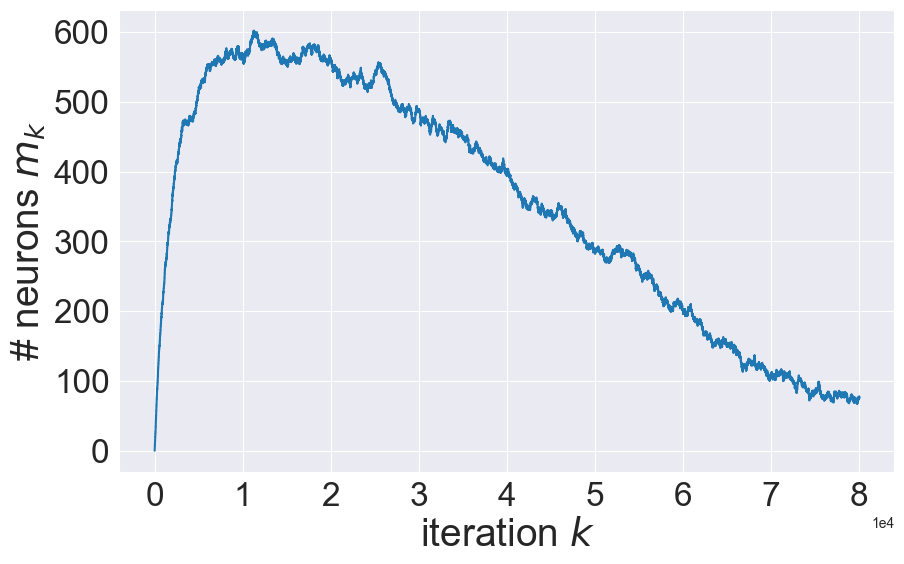

In [20]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(2*N_STEPS+1), ms)

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

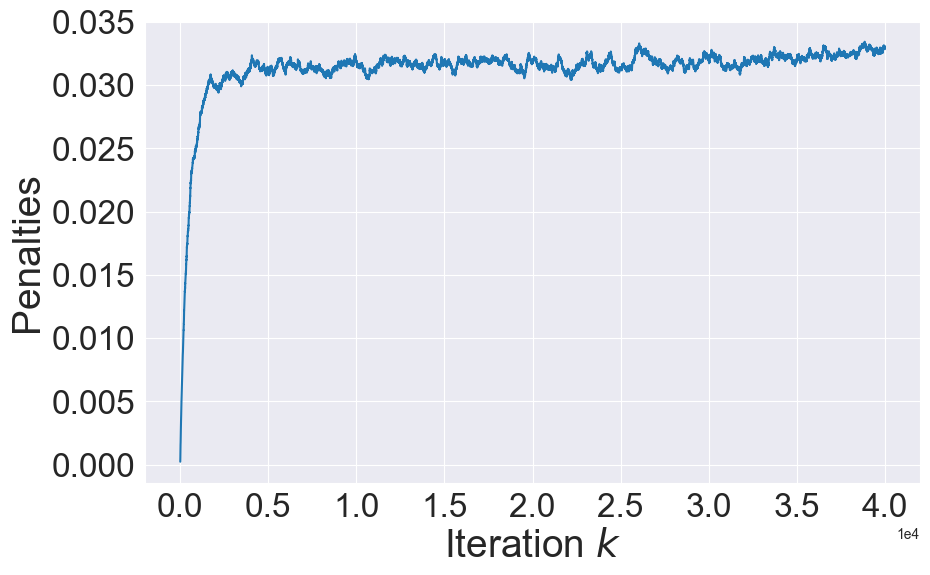

In [21]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

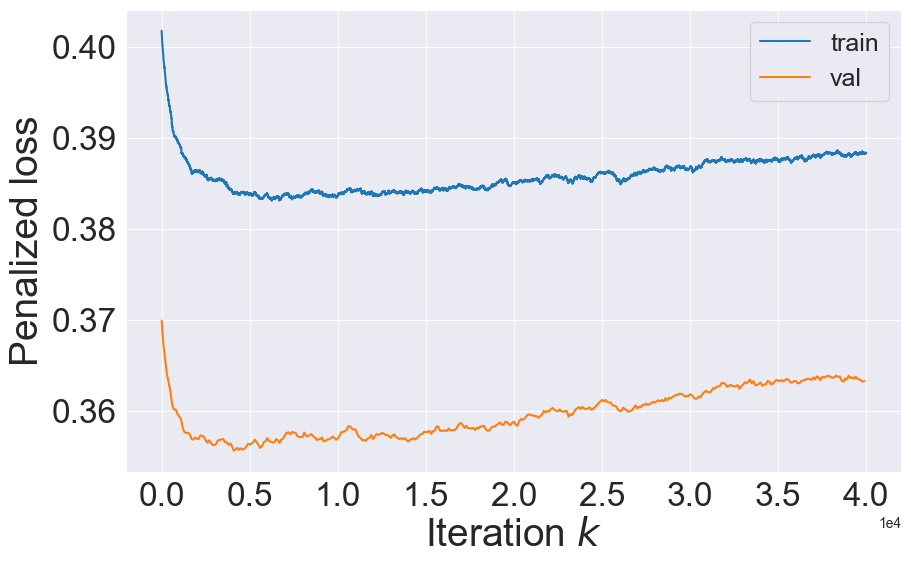

In [22]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

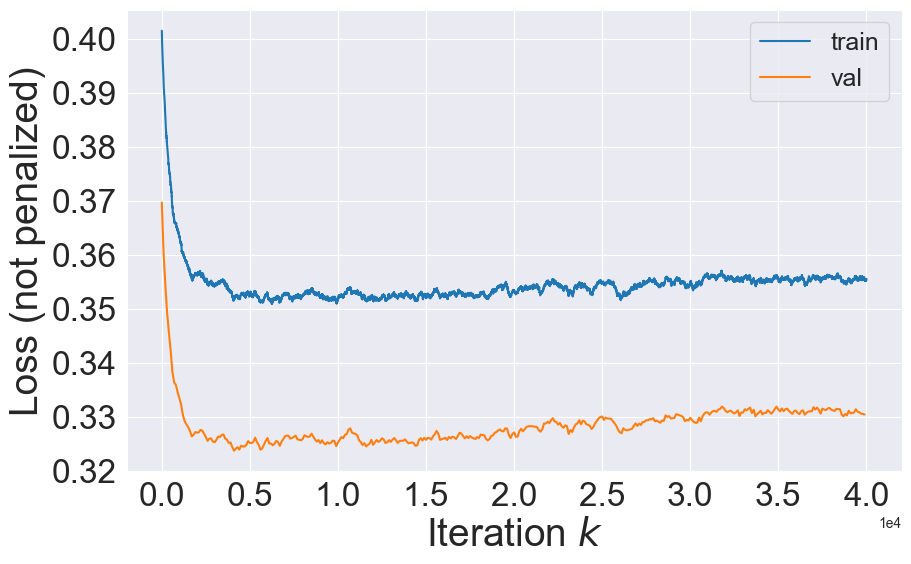

In [23]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val', 
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Loss (not penalized)', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()